# This notebook is the task that was given as a pre requisite for the project 5 of SRIP 2024
## Pratham Sharda(pratham.sharda@iitgn.ac.in)

# Binary classification with RESnet

So here first i have divided the dataset for two classes(I have take it for crab and flamingo) and first have run it without crossvalidation due to time constraint

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms

traindir = "D:/SRIP/Binary_task/Training"
testdir = "D:/SRIP/Binary_task/Validation"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [ ]:

def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [ ]:
from torchvision import datasets, models, transforms
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

In [ ]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [ ]:
%%capture
!pip install tqdm
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

In [ ]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Crab")
  else:
    print("Prediction : Flamingo")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

# Binary classification with cross validation(3 fold) 

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
import numpy as np
from sklearn.model_selection import KFold
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define directories (adjust paths as needed)
traindir = "D:/SRIP/Binary_task/Training"  # Assuming this now includes both training and validation data

# Transformations
transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset
dataset = datasets.ImageFolder(traindir, transform=transforms)

# KFold configuration
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Training parameters
n_epochs = 10
batch_size = 16

# Loss function
loss_fn = BCEWithLogitsLoss()

# Cross-validation
best_loss_overall = np.inf
best_model_wts_overall = None

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}/{kfold.n_splits}")

    # Sampler for splitting data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Data loaders for training and validation in this fold
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # Model setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

    best_loss = np.inf
    best_model_wts = copy.deepcopy(model.state_dict())

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epochs}, Fold {fold+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.unsqueeze(1).float()  # Ensure labels are float for BCELoss
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainloader.sampler)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                labels = labels.unsqueeze(1).float()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(testloader.sampler)
        print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    if best_loss < best_loss_overall:
        best_loss_overall = best_loss
        best_model_wts_overall = copy.deepcopy(best_model_wts)

# Load the best model weights from cross-validation
model.load_state_dict(best_model_wts_overall)

# You can now proceed with testing or inference using this model
# For example, here's a simple function to do inference on a single image from the dataset
def inference(dataset, model, device):
    model.eval()
    idx = np.random.randint(0, len(dataset))
    img, _ = dataset[idx]
    img = img.unsqueeze(0).to(device)  # Add batch dimension and transfer to device
    
    with torch.no_grad():
        output = model(img)
        prediction = torch.sigmoid(output).item()

    plt.imshow(dataset[idx][0].permute(1, 2, 0))
    plt.title(f"Prediction: {'Flamingo' if prediction >= 0.5 else 'Crab'}")
    plt.show()

# Example inference
inference(dataset, model, device)


# So now i have created the dataset for 5 class and one vs all classification

So I have take here for one vs rest classification the example of elephant that is is elephant or is not elephant
For 5 class I have converted the dataset into 5 groups where each group is divided based on some particular characteristics(mammals,reptiles,birds,insects and aquatic animals).This has been explicitly mentioned in the notebook below


Note: In this Github I have not uploaded the ARCHIVE/ANIMALS/ANIMALS FOLDER AS IT WAS OF TOO LARGE SIZE AND CONSIDERING I AM NOT TRAINING ON IT ,THUS I CHOSE NOW TO UPLOAD IT ON GITHUB BUT ALL IMPORTANT FILES HAVE BEEN UPLOADED ON WHICH TRAINING IS DONE

Creating one vs rest dataset

In [ ]:
import os
import shutil

# Define the source directory where the current dataset is stored
source_directory = 'D:/SRIP/archive/animals/animals'

# Define the destination directory where the new folder structure will be created
destination_directory = 'D:/SRIP/one_vs_rest_dataset'

# Define the names of the new subdirectories
elephant_dir = os.path.join(destination_directory, 'elephant')
other_animals_dir = os.path.join(destination_directory, 'other_animals')

# Create the destination directory and subdirectories if they don't already exist
os.makedirs(elephant_dir, exist_ok=True)
os.makedirs(other_animals_dir, exist_ok=True)

# Loop through each folder in the source directory
for folder_name in os.listdir(source_directory):
    # Define the path to the current folder
    current_folder_path = os.path.join(source_directory, folder_name)
    
    # Check if the current folder is indeed a directory
    if os.path.isdir(current_folder_path):
        # Determine the destination directory based on whether the folder is 'elephant' or not
        if folder_name.lower() == 'elephant':
            dest_dir = elephant_dir
        else:
            dest_dir = other_animals_dir
        
        # Loop through each file in the current folder
        for filename in os.listdir(current_folder_path):
            # Define the source and destination file paths
            source_file_path = os.path.join(current_folder_path, filename)
            destination_file_path = os.path.join(dest_dir, filename)
            
            # Copy the file from the source to the destination
            shutil.copy(source_file_path, destination_file_path)

print("Dataset reorganization complete.")


3 fold dataset creation for elephant vs rest animals 

In [ ]:
import os
import shutil
from sklearn.model_selection import KFold
import numpy as np

# Define the path to the directory containing the elephant and other_animals folders
dataset_directory = 'D:/SRIP/one_vs_rest_dataset'

# Define the main categories
categories = ['elephant', 'other_animals']

# Initialize KFold with 3 splits
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Process each category separately to split them into folds
for category in categories:
    # Path to the specific category directory
    category_path = os.path.join(dataset_directory, category)
    
    # List all files in the category directory
    files = np.array(os.listdir(category_path))
    
    # Apply KFold splitting
    for fold, (train_idx, val_idx) in enumerate(kf.split(files)):
        # Paths for train and validation directories for this fold
        fold_dir = os.path.join(dataset_directory, f'fold_{fold+1}', category)
        
        # Create the fold directory if it doesn't exist
        os.makedirs(fold_dir, exist_ok=True)
        
        # Validation files for this fold
        val_files = files[val_idx]
        
        # Copy validation files to the fold directory
        for file in val_files:
            src_file_path = os.path.join(category_path, file)
            dst_file_path = os.path.join(fold_dir, file)
            shutil.copy(src_file_path, dst_file_path)

print("3-Fold dataset split complete.")


5 Class dataset creation from the original dataset

Here I have divided the whole animla sclass into 5 class like Mammals, Birds,Aquatic animals and amphibians,Insects and arthropods,reptiles

In [ ]:
import os
import shutil

# Define your source and destination folders
src_folder = 'D:/SRIP/archive/animals/animals'
dest_folder = 'D:/SRIP/5_class_dataset'

# Mapping of animals to their classes
class_mapping = {
    'Mammals': ["Antelope", "Bear", "Bison", "Cat", "Chimpanzee", "Cow", "Coyote", "Deer", "Dog", "Dolphin", "Elephant", "Fox", "Gorilla", "Kangaroo", "Koala", "Leopard", "Lion", "Otter", "Panda", "Porcupine", "Raccoon", "Reindeer", "Rhinoceros", "Tiger", "Whale", "Wolf", "Zebra"],
    'Birds': ["Bat", "Eagle", "Flamingo", "Hummingbird", "Owl", "Parrot", "Pelecaniformes", "Penguin", "Pigeon", "Sparrow", "Turkey", "Woodpecker"],
    'Aquatic and Amphibious Animals': ["Crab", "Dolphin", "Goldfish", "Jellyfish", "Lobster", "Octopus", "Oyster", "Seahorse", "Seal", "Shark", "Starfish"],
    'Insects and Arthropods': ["Bee", "Beetle", "Butterfly", "Caterpillar", "Cockroach", "Dragonfly", "Fly", "Grasshopper", "Ladybugs", "Mosquito", "Moth"],
    'Reptiles and Others': ["Lizard", "Snake", "Turtle"]  # Assuming 'Crocodile' and 'Tortoise' aren't in your list but could be added if they were.
}

# Create the destination folder if it doesn't exist
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

# Create class folders and move files
for class_name, animals in class_mapping.items():
    class_folder = os.path.join(dest_folder, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    
    for animal in animals:
        animal_folder = os.path.join(src_folder, animal)
        if os.path.exists(animal_folder):
            for filename in os.listdir(animal_folder):
                src_file = os.path.join(animal_folder, filename)
                dest_file = os.path.join(class_folder, filename)
                # To avoid overwriting files with the same name from different folders, you could add a check here
                shutil.move(src_file, dest_file)

print("Images have been successfully reorganized into class-based folders.")


Craeting 3 fold dataset from the 5 class dataset so that we can have 3 folds for training and testing

In [ ]:
import os
import shutil
from sklearn.model_selection import KFold
import numpy as np

# Define the path to the directory containing the elephant and other_animals folders
dataset_directory = 'D:/SRIP/5_class_dataset'

# Define the main categories
categories = ['Mammals', 'Birds', 'Aquatic and Amphibious Animals', 'Insects and Arthropods', 'Reptiles and Others']

# Initialize KFold with 3 splits
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Process each category separately to split them into folds
for category in categories:
    # Path to the specific category directory
    category_path = os.path.join(dataset_directory, category)
    
    # List all files in the category directory
    files = np.array(os.listdir(category_path))
    
    # Apply KFold splitting
    for fold, (train_idx, val_idx) in enumerate(kf.split(files)):
        # Paths for train and validation directories for this fold
        fold_dir = os.path.join(dataset_directory, f'fold_{fold+1}', category)
        
        # Create the fold directory if it doesn't exist
        os.makedirs(fold_dir, exist_ok=True)
        
        # Validation files for this fold
        val_files = files[val_idx]
        
        # Copy validation files to the fold directory
        for file in val_files:
            src_file_path = os.path.join(category_path, file)
            dst_file_path = os.path.join(fold_dir, file)
            shutil.copy(src_file_path, dst_file_path)

print("3-Fold dataset split complete.")


# MODEL FOR 5 CLASS 

Now that we have created the datset for the model.



Now i am dividing each fold into training and test dataset and then fitting on the model and calculating the metrics to check its performance

In [1]:
import os
import random
import shutil

# Set the path to the folder containing the images
folder_path = "D:/folder/SRIP_Task/5_class_dataset/fold_1"

# Define the ratio of images to be used for training (0.8 = 80% training, 0.2 = 20% testing)
train_ratio = 0.8

# Create train and test directories if they don't exist
train_dir = os.path.join(folder_path, "train")
test_dir = os.path.join(folder_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all folders in the main folder
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    # Get the name of the subfolder (elephant or not elephant)
    label = os.path.basename(subfolder)
    
    # List all images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith(".jpg")]
    
    # Shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training
    num_train = int(train_ratio * len(images))
    
    # Split the images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy train images to the train directory
    for image in train_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    # Copy test images to the test directory
    for image in test_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully.")


Dataset split completed successfully.


In [2]:
import os
import random
import shutil

# Set the path to the folder containing the images
folder_path = "D:/folder/SRIP_Task/5_class_dataset/fold_2"

# Define the ratio of images to be used for training (0.8 = 80% training, 0.2 = 20% testing)
train_ratio = 0.8

# Create train and test directories if they don't exist
train_dir = os.path.join(folder_path, "train")
test_dir = os.path.join(folder_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all folders in the main folder
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    # Get the name of the subfolder (elephant or not elephant)
    label = os.path.basename(subfolder)
    
    # List all images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith(".jpg")]
    
    # Shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training
    num_train = int(train_ratio * len(images))
    
    # Split the images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy train images to the train directory
    for image in train_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    # Copy test images to the test directory
    for image in test_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully.")


Dataset split completed successfully.


In [3]:
import os
import random
import shutil

# Set the path to the folder containing the images
folder_path = "D:/folder/SRIP_Task/5_class_dataset/fold_3"

# Define the ratio of images to be used for training (0.8 = 80% training, 0.2 = 20% testing)
train_ratio = 0.8

# Create train and test directories if they don't exist
train_dir = os.path.join(folder_path, "train")
test_dir = os.path.join(folder_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all folders in the main folder
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    # Get the name of the subfolder (elephant or not elephant)
    label = os.path.basename(subfolder)
    
    # List all images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith(".jpg")]
    
    # Shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training
    num_train = int(train_ratio * len(images))
    
    # Split the images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy train images to the train directory
    for image in train_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    # Copy test images to the test directory
    for image in test_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Now I have built and used this custom model 

There have been extra function kept in it like the forward with visualisation and intermediate outputs as it would help in getting the feature map

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Additional Convolutional Layers for More Complexity
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(256)


        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  
        self.dropout = nn.Dropout(0.5)  # Introducing Dropout
        self.fc2 = nn.Linear(1024, 512)  # Additional Dense Layer
        self.fc3 = nn.Linear(512, 5)  # Assuming 5 classes

    def forward_with_visualization(self, x):
        # Collect outputs for visualization
        vis_outputs = []

        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        vis_outputs.append(x)
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        vis_outputs.append(x)
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        vis_outputs.append(x)
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        vis_outputs.append(x)

        # Continue with the rest of the model (optional if you just want the conv layer outputs)
        x = x.view(-1, 256 * 14 * 14)  # Adjust based on your architecture
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        # Return both the final output (optional) and the intermediate outputs for visualization
        return x, vis_outputs

    def get_intermediate_outputs(self, x):
        outputs = []
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        outputs.append(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        outputs.append(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        outputs.append(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        outputs.append(x)
        
        # Optionally, continue through the rest of your network
        # and return the final classification output as well if needed
        
        return outputs  # Returns a list of the outputs after each conv layer

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 256 * 14 * 14)  # Update this calculation based on your architecture's output size
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Applying Dropout here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def load_datasets(fold_path):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dir = os.path.join(fold_path, 'train')
    test_dir = os.path.join(fold_path, 'test')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=image_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=image_transform)

    return train_dataset, test_dataset

from sklearn.metrics import confusion_matrix, classification_report
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=15):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        print(f"Epoch {epoch+1} completed.")

    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy}%')

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)

    # Generate classification report
    target_names = ['Aquatic', 'Birds', 'insects', 'Mammals', 'Reptiles']  
    classification_rep = classification_report(true_labels, predicted_labels, target_names=target_names)
    print("Classification Report:")
    print(classification_rep)
    



In [ ]:
parent_dir = 'D:/folder/SRIP_Task/5_class_dataset'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

for fold in range(1, 4):  # Assuming there are 3 folds
    print(f"Training on Fold {fold}")
    fold_path = f'{parent_dir}/fold_{fold}'
    train_dataset, test_dataset = load_datasets(fold_path)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=25)




torch.save(model.state_dict(), '5_class_best_fold.pth')

From the above results of training and testing we find that the accuracy is not that high and many images are prdicted in the class 4(mammals) catagory.It was after this training that i realaised that the divison into 5 class was not very unifrom by me as mammals had many classes in then while some like reptiles had very few animals in them thus there wasn't sufficient data to train on all the 5 classes and this unequal distribution thus creates a bias of predicting mammals more as it had more data to be trained on.

Thuas i learnt that data should be divided equally so that there is no bias in testing

Now here I visulaise the layers and its feature maps.
After plotting for each layer we observe that some part of models are looking at gradients,some are looking at vertical edges ,some are looking at horizontal edges ,some at foreground and some at background


Also we see that as the layers process they accumlate the data and apply the max pooling thus detecting more general features,like first layers just see edge,but the further layers try to predict the boundary of the animal's body ,thus it starts with basic features and integrates them to get a more complex feature in next layer,thus integrating features from previous layer to get more complex features in next layer

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms

def predict_and_display_image(model, image_path, class_names):
    
    # Ensure the model is in evaluation mode
    model.eval()

    # Image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Move the input and model to the right device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)
    model = model.to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        _, predicted_idx = torch.max(output, 1)

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_idx.item()]}, Probability: {probabilities[predicted_idx].item():.2f}")
    plt.axis('off')
    plt.show()

# Example usage
class_names = ['Aquatic', 'Birds', 'insects', 'Mammals', 'Reptiles']   

model = CustomCNN()
model.load_state_dict(torch.load('5_class_best_fold.pth'))

model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# Path to the image you want to predict
image_path = 'path/image.jpg'

# Call the prediction function
predict_and_display_image(model, image_path, class_names)


The above function takes a image and predicts its class

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_maps(feature_maps):
    # Plot the feature maps
    for layer_idx, fmap in enumerate(feature_maps):
        num_features = fmap.size(1)
        fig, axes = plt.subplots(1, min(num_features, 8), figsize=(20, 2.5))  # Displaying up to 8 feature maps per layer
        for i, ax in enumerate(axes):
            ax.imshow(fmap[0, i].cpu().detach().numpy(), cmap='viridis')
            ax.axis('off')
        plt.title(f'Layer {layer_idx+1} Feature Maps')
        plt.show()


from PIL import Image
from torchvision import transforms

# Load the image
image_path = '/content/SRIP_Task/5_class_dataset/fold_1/test/Mammals/051c0550cd.jpg'
input_image = Image.open(image_path)

# Define the same transforms as during training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image and add batch dimension
input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)


model.eval()  # Set the model to evaluation mode


input_tensor = input_tensor.to(device)


_, feature_maps = model.forward_with_visualization(input_tensor)

# Now plot the feature maps
plot_feature_maps(feature_maps)

The above plotted the feature map after each conv layer after all the max pooling in each layer.

Now below we plot the intermediate features 

In [ ]:
# Ensure your model instance is up-to-date with the new method
model = CustomCNN().to(device)

# Assuming `input_tensor` is your preprocessed input image ready for the model
input_tensor = input_tensor.to(device)

# Get intermediate outputs
intermediate_outputs = model.get_intermediate_outputs(input_tensor)

# Now you can use the previously defined `plot_feature_maps` function to visualize
plot_feature_maps(intermediate_outputs)


So now i also had read about the saliency map,so i tried lotting the saliency map for the image using gradients to understand it better where in the image the model is focusing more and thus help us to get which features are being understood by model

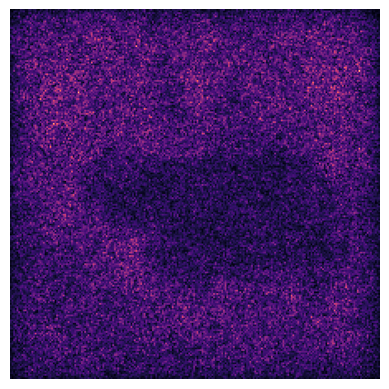

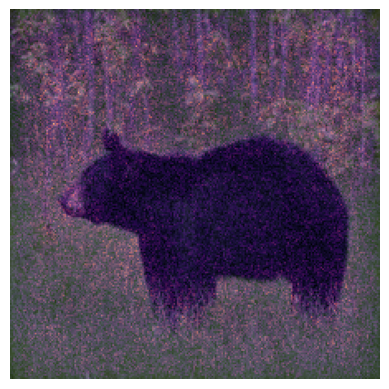

In [44]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = 'D:/folder/SRIP_Task/5_class_dataset/fold_1/test/Mammals/4e7dc3eb5f.jpg'
input_image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).unsqueeze(0)  # Add a batch dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)


model.eval()
input_tensor.requires_grad_()  # Enable gradient tracking on the input

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()
    input_tensor=torch.tensor(input_tensor,requires_grad=True)

# Forward pass
output = model(input_tensor)

# Assume you are interested in the highest scoring class
# You might need to adjust this depending on your specific task
output_idx = output.argmax()
output_max = output[0, output_idx]

# Backward pass
model.zero_grad()
output_max.backward()
# print(input_tensor)
# print(input_tensor.requires_grad_())
# assert input_tensor.grad is not None, "Gradients were not computed"

# Compute saliency map

saliency, _ = torch.max(abs(input_tensor.grad)/100, dim=1)
saliency = saliency.reshape(224, 224)

import matplotlib.pyplot as plt

# Display the saliency map
plt.imshow(saliency.cpu(), cmap='magma')
plt.axis('off')
plt.show()


import numpy as np

# Convert PIL image to NumPy array
# Ensure input_image is the original PIL image loaded before preprocessing
image_array = np.array(input_image.resize((224, 224)))
import matplotlib.pyplot as plt

# Display the original image
plt.imshow(image_array)

# Overlay the saliency map as a heatmap
# 'alpha' controls the transparency of the overlay
plt.imshow(saliency.cpu().detach().numpy(), cmap='magma', alpha=0.6)  # Adjust alpha as needed

plt.axis('off')  # Hide axes
plt.show()





# one vs rest classification

So in the one vs rest classification i have done it for elephant vs others ,similarly it can be done for any animal as such

So first i am dividing the dataset so that it can be used for training and testing

In [1]:
import os
import random
import shutil

# Set the path to the folder containing the images
folder_path = "D:/folder/SRIP_Task/one_vs_rest_dataset/fold_1"

# Define the ratio of images to be used for training (0.8 = 80% training, 0.2 = 20% testing)
train_ratio = 0.8

# Create train and test directories if they don't exist
train_dir = os.path.join(folder_path, "train")
test_dir = os.path.join(folder_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all folders in the main folder
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    # Get the name of the subfolder (elephant or not elephant)
    label = os.path.basename(subfolder)
    
    # List all images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith(".jpg")]
    
    # Shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training
    num_train = int(train_ratio * len(images))
    
    # Split the images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy train images to the train directory
    for image in train_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    # Copy test images to the test directory
    for image in test_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully.")


Dataset split completed successfully.


In [2]:
import os
import random
import shutil

# Set the path to the folder containing the images
folder_path = "D:/folder/SRIP_Task/one_vs_rest_dataset/fold_2"

# Define the ratio of images to be used for training (0.8 = 80% training, 0.2 = 20% testing)
train_ratio = 0.8

# Create train and test directories if they don't exist
train_dir = os.path.join(folder_path, "train")
test_dir = os.path.join(folder_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all folders in the main folder
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    # Get the name of the subfolder (elephant or not elephant)
    label = os.path.basename(subfolder)
    
    # List all images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith(".jpg")]
    
    # Shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training
    num_train = int(train_ratio * len(images))
    
    # Split the images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy train images to the train directory
    for image in train_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    # Copy test images to the test directory
    for image in test_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully.")


Dataset split completed successfully.


In [3]:
import os
import random
import shutil

# Set the path to the folder containing the images
folder_path = "D:/folder/SRIP_Task/one_vs_rest_dataset/fold_3"

# Define the ratio of images to be used for training (0.8 = 80% training, 0.2 = 20% testing)
train_ratio = 0.8

# Create train and test directories if they don't exist
train_dir = os.path.join(folder_path, "train")
test_dir = os.path.join(folder_path, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all folders in the main folder
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    # Get the name of the subfolder (elephant or not elephant)
    label = os.path.basename(subfolder)
    
    # List all images in the subfolder
    images = [f for f in os.listdir(subfolder) if f.endswith(".jpg")]
    
    # Shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training
    num_train = int(train_ratio * len(images))
    
    # Split the images into train and test sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy train images to the train directory
    for image in train_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    # Copy test images to the test directory
    for image in test_images:
        src = os.path.join(subfolder, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Dataset split completed successfully.")


Dataset split completed successfully.


So here i define the model for one vs rest classification

Some initial thoughts:
I feel that this won't turn out to be a very good model beacuse the amaount of training data for not elephants is very large as copared to that of elephants(60 only in comparision to 89*60)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import os

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Assuming 3-channel input images
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)  # Adjust size according to your image size
        self.fc2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)  # Adjust flattening size according to your image size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
def get_data_loader(root_dir, fold, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Adjust the path to where your data is stored
    train_data = ImageFolder(root=os.path.join(root_dir, f'fold_{fold}', 'train'), transform=transform)
    test_data = ImageFolder(root=os.path.join(root_dir, f'fold_{fold}', 'test'), transform=transform)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [16]:
def train_and_evaluate(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy}%')

    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Not Elephant', 'Elephant']))
    
    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    return accuracy


In [ ]:
root_dir = '/content/SRIP_Task/one_vs_rest_dataset'  # Adjust this path
n_folds = 3
batch_size = 64
epochs = 15

accuracies = []
best_accuracy = 0.0
best_fold = 0
model = SimpleCNN()
for fold in range(1, n_folds+1):
    print(f'Starting fold {fold}')
    train_loader, test_loader = get_data_loader(root_dir, fold, batch_size)
    
    accuracy = train_and_evaluate(model, train_loader, test_loader, epochs)
    accuracies.append(accuracy)


        
        
torch.save(model.state_dict(), 'best_model.pth')
# Calculate and print the average accuracy
average_accuracy = np.mean(accuracies)
print(f'Average Accuracy: {average_accuracy}%')


Thus as expected due to unbalanced datathe accuracy is very high but the actual performance is very poor due to less data for elephants,thus othere parameters are very less and only accuracy is good ,so in such tasks we must gather more data so that there is equal data for both the classes,This was the main inference from one vs rest classification.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def predict_and_display_image(model, image_path, class_names):
   
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Image preprocessing steps should match those used during training
    preprocess = transforms.Compose([
        transforms.Resize((64, 64)),  # Match this with your dataset preprocessing
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Match these values with your dataset preprocessing
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Move the input and model to the right device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)
    model = model.to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_idx = probabilities.argmax(1).item()

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_idx]}, Probability: {probabilities[0, predicted_idx].item():.2f}")
    plt.axis('off')
    plt.show()


model = SimpleCNN()
model.load_state_dict(torch.load('best_model.pth'))

model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class_names = ['elephant', 'not elephant']  # Update these based on your actual classes

# Path to the image you want to predict
image_path = '/content/SRIP_Task/one_vs_rest_dataset/fold_1/test/elephant/0e757af2d5.jpg'

# Call the prediction function
predict_and_display_image(model, image_path, class_names)

This takes a image path and a model with already loaded weights and tries to predict the class using model and image path 